# E. coli Promoter Classification with Genomic Ensemble Pretraining

This notebook follows the same form as the previous notebook, but changes the pretrained model used for classification. Instead of training only on the E. coli genome, the language model used was trained on an ensemble of bacterial genomes. 

Point of clarification: When I use the term ensemble here, I mean a dataset composed of multiple bacterial genomes. Not multiple models trained in an ensemble.

The genomes used in the ensemble and the training of the model are documented in the `Bacterial Ensemble 1 Language Model` notebook. The ensemble language model trains to a lower loss than the pure E. coli language model. As shown below, using the pretrained weights from the ensemble model as the starting point for the promoter classification model produces significantly better results. This implies that the quality of the pretrained language model has a significant impact on the performance of the classification model.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import networkx as nx

In [3]:
sys.path.append("../..")
from utils import *

In [4]:
path = Path('F:/genome/e_coli/')
path_bact = Path('F:/genome/bacterial genomes/')

# Classification

In [5]:
classification_df = pd.read_csv(path/'e_coli_promoters_dataset.csv')

In [6]:
classification_df.head()

,Gene,Locus,Location,Sample Location,Orientation,Sequence,Promoter,Independent,set
0,['mokC'],['b0018'],[16750:16960](-),[16910:17060](-),reverse,TAGCGGCGGGTGCTTGAGGCTGTCTGTCTCAGGCATTAGCTGAACG...,1,False,train
1,['insB-1'],['b0021'],[19810:20314](-),[20264:20414](-),reverse,GCTCTCACTGCCGTAAAACATGGCAACTGCAGTTCACTTACACCGC...,1,False,train
2,['insA-1'],['b0022'],[20232:20508](-),[20458:20608](-),reverse,GACTCCCCCACAAAGAATATGGATATTGTGATACACATTGAGGTAG...,1,False,train
3,['rpsT'],['b0023'],[20814:21078](-),[21028:21178](-),reverse,ACGGCGCTTATTTGCACAAATCCATTGACAAAAGAAGGCTAAAAGG...,1,False,train
4,['fkpB'],['b0028'],[25825:26275](+),[25725:25875](+),forward,ACGCATCTTATCCGGCCTACAGATTGCTGCGAAATCGTAGGCCGGA...,1,False,train


In [7]:
train_df = classification_df[classification_df.set == 'train']
valid_df = classification_df[classification_df.set == 'valid']
test_df = classification_df[classification_df.set == 'test']

Here we create a dataloader with the vocabulary used for the bacterial ensemble model

In [8]:
voc = np.load(path_bact/'bact_vocab.npy')
model_vocab = GenomicVocab(voc)

In [9]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, valid_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Promoter', bs=300)

In [12]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4, 
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.4

In [13]:
learn = get_model_clas(data_clas, drop_mult, clas_config)

In [14]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(1025, 400, padding_idx=0)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(1025, 400, padding_idx=0)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.16000000000000003)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e

In [15]:
learn.load_encoder('b2_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-02


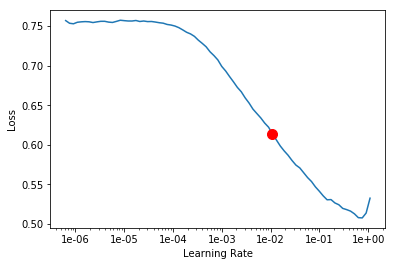

In [16]:
learn.lr_find()
learn.recorder.plot()

Here we follow the same training procedure as before

In [16]:
learn.fit_one_cycle(3, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.299788,0.402819,0.906667
2,0.227257,0.322457,0.874667
3,0.196680,0.190672,0.928000


In [17]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.147245,0.103063,0.960000
2,0.123434,0.096796,0.970667
3,0.102523,0.098481,0.965333


In [18]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.069349,0.096312,0.972000
2,0.060054,0.089070,0.970667
3,0.051752,0.089726,0.969333


In [19]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.038490,0.084667,0.972000
2,0.037266,0.084177,0.977333
3,0.035116,0.089602,0.972000
4,0.032901,0.091328,0.970667
5,0.031205,0.090164,0.970667


In [20]:
learn.fit_one_cycle(5, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.027921,0.089311,0.970667
2,0.028479,0.090258,0.970667
3,0.026315,0.088215,0.973333
4,0.026514,0.086736,0.978667
5,0.025715,0.089114,0.970667


In [21]:
learn.save('coli_bact_pretrain')

# Test

In [22]:
data_clas = GenomicTextClasDataBunch.from_df(path, train_df, test_df, tokenizer=tok, vocab=model_vocab,
                                            text_cols='Sequence', label_cols='Promoter', bs=300)
learn.data = data_clas

In [23]:
get_scores(learn)

Accuracy: 0.9734939759036144
False Positives: 0.00963855421686747
False Negatives: 0.016867469879518072
Recall: 0.9662650602409638
Precision: 0.980440097799511
MCC: 0.9470869412448478


The bacterial ensemble pretrained model easily beats the E. coli genome pretrained model. The E. coli pretrained model trained to a validation loss of 0.24, while the ensemble pretrained model trained to a validation loss of 

Comparing this model to the E. coli pretrained model, accuracy increased from 91.9% to 97.3%, precision increased from 0.94 to 0.98, recall increased from 0.89 to 0.96, and MCC increased from 0.839 to 0.947.

The models were trained on the classification dataset for the same number of epochs. The increased performance shows the impact of a well trained language model on this technique. In addition to improved performance, the ensemble pretrained model overfit less and required less regularization (lower dropout).